<a href="https://colab.research.google.com/github/TalCobra/DeepLearning_Wine_Classification/blob/main/Qualidade_de_vinho_DL%2Bautoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras import regularizers
# Definir a seed para reprodutibilidade
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

initializer = tf.keras.initializers.GlorotUniform(seed=seed)

tf.config.experimental.enable_op_determinism()

In [ ]:

data = pd.read_csv('/content/winequality-white new.csv')
Y = data['quality']
X = data.drop(columns=['quality'])


X['alcohol'] = X['alcohol'].str.replace('R$', '').str.replace('.', '').str.replace(',', '.').str.strip().astype(float)

# One-hot encoding para Y
Y = pd.get_dummies(Y, prefix='quality')

# Normalização
scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
Y_scaled = Y.values


X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42)


model_original = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(Y_train.shape[1], activation='softmax')
])


model_original.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history_original = model_original.fit(
    X_train, Y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, Y_test),
    verbose=1
)

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4072 - loss: 1.4623 - val_accuracy: 0.4408 - val_loss: 1.2630
Epoch 2/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4471 - loss: 1.2861 - val_accuracy: 0.4429 - val_loss: 1.2530
Epoch 3/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4515 - loss: 1.2696 - val_accuracy: 0.4469 - val_loss: 1.2468
Epoch 4/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4502 - loss: 1.2592 - val_accuracy: 0.4490 - val_loss: 1.2396
Epoch 5/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4591 - loss: 1.2515 - val_accuracy: 0.4510 - val_loss: 1.2339
Epoch 6/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4601 - loss: 1.2392 - val_accuracy: 0.4500 - val_loss: 1.2238
Epoch 7/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4617 - loss: 1.2274 - val_accuracy: 0.4490 - val_loss: 1.2163
Epoch 8/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4734 - loss: 1.2179 - val_accuracy: 0.446

In [ ]:
# Parâmetros do autoencoder
encoding_dim = 64  # Dimensão do espaço latente

# Autoencoder
input_layer = Input(shape=(X_train.shape[1],))
encoded = Dense(512, activation='relu', activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = Dropout(0.3)(encoded)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dropout(0.2)(encoded)
bottleneck = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(256, activation='relu')(bottleneck)
decoded = Dropout(0.2)(decoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dropout(0.3)(decoded)
decoded = Dense(X_train.shape[1], activation='sigmoid')(decoded)

# Modelo completo do autoencoder
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Treinar apenas o autoencoder
autoencoder.fit(
    X_train, X_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, X_test),
    verbose=1
)

# Extrair o encoder (para feature extraction)
encoder = Model(input_layer, bottleneck)

# Classificador usando as features aprendidas
classifier_input = Input(shape=(encoding_dim,))
classifier = Dense(128, activation='relu')(classifier_input)
classifier = Dropout(0.2)(classifier)
classifier = Dense(Y_train.shape[1], activation='softmax')(classifier)

model_autoencoder = Model(classifier_input, classifier)
model_autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Obter representações latentes
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Treinar o classificador
history_autoencoder = model_autoencoder.fit(
    X_train_encoded, Y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test_encoded, Y_test),
    verbose=1
)

Epoch 1/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0422 - val_loss: 0.0081
Epoch 2/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0072 - val_loss: 0.0034
Epoch 3/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 4/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 5/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 6/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 7/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 8/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 9/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 10/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 11/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 12/500
123/123 ━━━━━━━━━


Comparação Final:
Modelo Original - Loss: 1.4492, Acurácia: 0.6112
Autoencoder - Loss: 1.3597, Acurácia: 0.5500


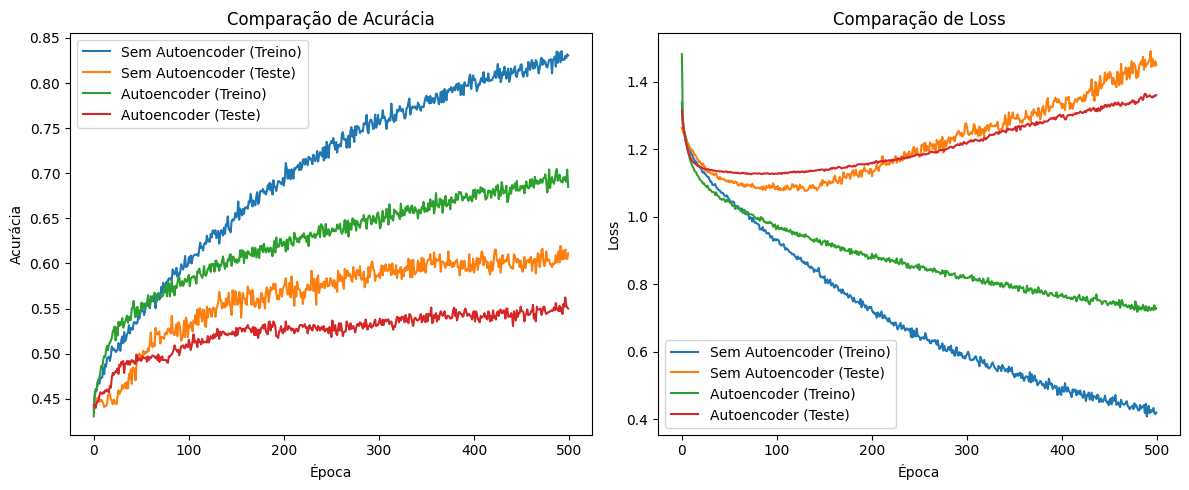

In [ ]:
# Avaliar ambos os modelos
results_original = model_original.evaluate(X_test, Y_test, verbose=0)
results_autoencoder = model_autoencoder.evaluate(X_test_encoded, Y_test, verbose=0)

print("\nComparação Final:")
print(f"Modelo Original - Loss: {results_original[0]:.4f}, Acurácia: {results_original[1]:.4f}")
print(f"Autoencoder - Loss: {results_autoencoder[0]:.4f}, Acurácia: {results_autoencoder[1]:.4f}")

# Plotar comparação
plt.figure(figsize=(12, 5))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(history_original.history['accuracy'], label='Sem Autoencoder (Treino)')
plt.plot(history_original.history['val_accuracy'], label='Sem Autoencoder (Teste)')
plt.plot(history_autoencoder.history['accuracy'], label='Autoencoder (Treino)')
plt.plot(history_autoencoder.history['val_accuracy'], label='Autoencoder (Teste)')
plt.title('Comparação de Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend()

# Gráfico de Loss
plt.subplot(1, 2, 2)
plt.plot(history_original.history['loss'], label='Sem Autoencoder (Treino)')
plt.plot(history_original.history['val_loss'], label='Sem Autoencoder (Teste)')
plt.plot(history_autoencoder.history['loss'], label='Autoencoder (Treino)')
plt.plot(history_autoencoder.history['val_loss'], label='Autoencoder (Teste)')
plt.title('Comparação de Loss')
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend()

plt.tight_layout()
plt.show()